# Aplicando Transformers para Classificação

A implementação de um sistema automatizado de aprendizado de máquina torna o processo de classificação de textos mais eficiente. Um sistema como esse, equipado com capacidades avançadas de processamento de linguagem natural e aprendizado de máquina, poderia analisar vastos arquivos, categorizando artigos em seus respectivos tópicos com notável precisão. Como resultado, os leitores teriam acesso fluido a uma riqueza de conhecimento adaptada aos seus interesses, enquanto a equipe editorial ganharia uma agilidade inédita na gestão de conteúdo.

Neste projeto, o objetivo é desenvolver um modelo com a tarefa de classificar artigos de notícias para um mecanismo de busca de conteúdo. Vamos construir um modelo que possa categorizar automaticamente os artigos de notícias em diferentes tópicos ou classes, permitindo que o mecanismo de busca entregue conteúdo relevante aos usuários de forma eficiente. Para alcançar isso, vamos usar a biblioteca `torchtext`, que simplifica o processo de criação de um conjunto de dados para análise de classificação de texto.

Com o `torchtext`, temos a flexibilidade de acessar e pré-processar dados brutos de notícias de forma descomplicada. A biblioteca permite converter cadeias de texto em `torch.Tensors`, que são essenciais para treinar modelos de aprendizado de máquina. Usando as funcionalidades convenientes do `torchtext`, podemos configurar um pipeline eficiente de processamento de dados que prepara seus textos para classificação.

Vamos embaralhar e iterar eficazmente os dados processados usando o `torch.utils.data.DataLoader`. Este DataLoader simplifica o gerenciamento dos dados, permitindo que você foque na construção e no treinamento do seu modelo de classificação de texto de forma eficiente.

O infográfico a seguir, criado pela IBM, fornece uma visão geral do funcionamento interno dos transformadores
![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/Tokenization%20-%20Color.jpeg)


# Objetivos
- Trabalhar com conjuntos de dados e entender o tokenizador, a técnica de embedding bag e o vocabulário
- Explorar embeddings no PyTorch e entender os índices de token
- Executar a classificação de texto usando o carregador de dados e aplicá-lo em um modelo de rede neural
- Treinar o modelo de classificação de texto em um conjunto de dados de notícias

### Preparar setup

In [1]:
def warn(*args, **kwargs):
    pass
    
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib.util
import subprocess
import sys

def check_and_install(package, pip_name=None):
    if pip_name is None:
        pip_name = package
    spec = importlib.util.find_spec(package)
    if spec is None:
        print(f"{package} não está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    else:
        print(f"{package} já está instalado.")

In [3]:
'''
check_and_install('dash-core-components', 'dash-core-components==2.0.0')
check_and_install('dash-table', 'dash-table==5.0.0')
check_and_install('dash', 'dash==2.9.3')
check_and_install('dash-html-components', 'dash-html-components==2.0.0')
check_and_install('portalocker', 'portalocker>=2.0.0')
check_and_install('torchtext', 'torchtext==0.18')
check_and_install('torchdata')
check_and_install('plotly')
'''

"\ncheck_and_install('dash-core-components', 'dash-core-components==2.0.0')\ncheck_and_install('dash-table', 'dash-table==5.0.0')\ncheck_and_install('dash', 'dash==2.9.3')\ncheck_and_install('dash-html-components', 'dash-html-components==2.0.0')\ncheck_and_install('portalocker', 'portalocker>=2.0.0')\ncheck_and_install('torchtext', 'torchtext==0.18')\ncheck_and_install('torchdata')\ncheck_and_install('plotly')\n"

### Importar bibliotecas

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
import numpy as np
from IPython.display import Markdown as md
from tqdm import tqdm

from torch.utils.data.dataset import random_split
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import pickle

from torch.nn.utils.rnn import pad_sequence

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset

### Definir funções auxiliares

In [4]:
def plot(COST,ACC):
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [5]:
def plot_embdings(my_embdings,name,vocab):
  
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [6]:
def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")

In [7]:
def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

In [8]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

In [98]:
def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

### Toy dataset
O código define um conjunto de dados, tokeniza os dados de texto usando um tokenizador básico de inglês, cria um vocabulário a partir dos dados tokenizados e configura um índice padrão para lidar com tokens desconhecidos.

In [9]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
]

In [10]:
tokenizer = get_tokenizer("basic_english")

In [11]:
def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

In [12]:
vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Prepare o pipeline de processamento de texto com o tokenizer e o vocabulário. Os pipelines de texto e rótulo serão usados ​​para processar as strings de dados brutos dos iteradores do conjunto de dados.

A função **```text_pipeline```** tokenizará o texto de entrada e **```vocab```** será então aplicado para obter os índices de token.
O **```label_pipeline```** garantirá que os rótulos comecem em zero.

Esses pipelines são definidos aqui para uso futuro.

In [13]:
def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1

### Zero padding
Em várias aplicações PyTorch, garantir tamanhos de lote consistentes é um requisito fundamental. Isso requer o uso de zero-padding para harmonizar comprimentos de sequência variáveis ​​dentro de cada lote, você pode fazer isso usando ```pad_sequence```, considere a lista de tensores de comprimentos diferentes:

In [14]:
sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

A função `pad_sequence` de `torch.nn.utils.rnn` no PyTorch é usada para preencher uma sequência de tensores com o mesmo comprimento ao longo de uma dimensão especificada. Esta função é comumente usada ao lidar com sequências de comprimentos variáveis, como em tarefas de processamento de linguagem natural (NLP) ao trabalhar com sentenças tokenizadas de comprimentos diferentes.

Veja como funciona:

1. **Entrada**: `pad_sequence` recebe uma lista de tensores como entrada, onde cada tensor representa uma sequência. Essas sequências podem ter comprimentos diferentes.
2. **Preenchimento**: A função preenche as sequências com zeros (ou outro valor de preenchimento especificado) para torná-las todas do mesmo comprimento. Ela preenche as sequências para corresponder ao comprimento da sequência mais longa na lista.
3. **Saída**: A saída é um único tensor onde todas as sequências são empilhadas ao longo da dimensão especificada (por padrão, é a primeira dimensão). O resultado é um lote de sequências com o mesmo comprimento.

In [15]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


## Codificações posicionais (positional encodings)

Codificações posicionais desempenham um papel fundamental em transformadores e vários modelos de sequência para sequência, auxiliando na transmissão de informações críticas sobre as posições ou sequenciamento de elementos dentro de uma determinada sequência. 

Para ilustrar, vamos examinar as frases: "He painted the car red" e "He painted the red car.". Apesar de seus significados distintos, vale a pena notar que os embeddings para essas frases permanecem idênticos, conforme mostrado aqui:

In [16]:
my_tokens = 'he painted the car red he painted the red car'

In [17]:
my_index = text_pipeline(my_tokens)
my_index

[12, 13, 15, 11, 14, 12, 13, 15, 14, 11]

In [18]:
embedding_dim = 3

vocab_size = len(vocab)
print(vocab_size)

27


In [19]:
embedding = nn.Embedding(vocab_size, embedding_dim)

In [20]:
my_embeddings=embedding(torch.tensor(my_index)).detach().numpy()

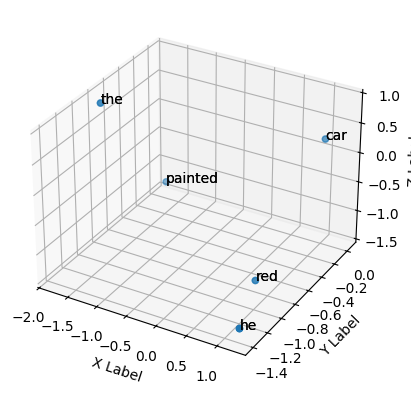

In [21]:
plot_embdings(my_embeddings,tokenizer(my_tokens),vocab)

Você pode representar efetivamente a posição de cada amostra dentro de uma sequência associando-a ao seu índice de posição correspondente, expressando a codificação posicional como $p_{n}=n$, onde $n$ representa a posição da amostra na sequência. Para ilustrar, você pode atribuir o índice 0 à codificação inicial, o índice 1 à segunda, e assim por diante. Essa abordagem permanece robusta mesmo ao lidar com sequências de comprimento considerável, estendendo-se até onde seu vocabulário permitir.


In [22]:
position = torch.arange(0, vocab_size, dtype = torch.float).unsqueeze(1)
position

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.]])

Você pode atribuir importância a cada dimensão \(d\) dentro da incorporação, denotando-a como $\textbf{p}_{n,d}$. Por exemplo, no caso de uma dimensão de incorporação de três, as codificações posicionais $\textbf{p}_{n,d}$ seriam representadas como $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$, que, por sua vez, corresponde a uma incorporação tridimensional de cada token.

In [23]:
d_model = 3
pe = torch.zeros(vocab_size, d_model)

In [24]:
pe = torch.cat((position, position, position), 1)
pe

tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

Você só precisa de codificações posicionais para cada sequência de embeddings e, para determinar isso, basta contar o número de embeddings na sequência.

In [25]:
samples, dim = my_embeddings.shape
samples, dim

(10, 3)

Depois de adicionar as codificações posicionais aos embeddings e plotar os resultados, você observará que eles são diferentes.

In [26]:
pos_embeddings = my_embeddings + pe[0:samples,:].numpy()

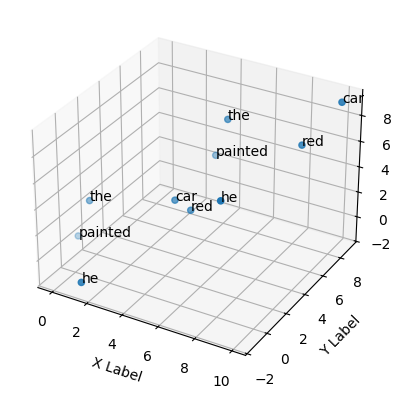

In [27]:
plot_embdings(pos_embeddings, tokenizer(my_tokens), vocab)

Um problema decorrente da integração de codificações posicionais lineares está no aumento substancial na magnitude de embeddings para posições mais adiante na sequência. Esse fenômeno se torna particularmente pronunciado ao lidar com sequências extensas. Por exemplo, ao examinar os embeddings para a palavra "car" nos índices 3 e 9, você observará que o embedding na posição 9 é notavelmente maior. Essa disparidade se intensifica à medida que o comprimento da sequência aumenta. Dado que os embeddings são feitos para representar palavras, tente evitar divergência excessiva dos embeddings originais.

In [28]:
# add -3 to get original embedding
pos_embeddings[3]

array([3.9886255, 3.038396 , 3.2070856], dtype=float32)

In [29]:
# add -9 original embedding
pos_embeddings[-1]

array([9.988626, 9.038396, 9.207086], dtype=float32)

Você pode abordar essa questão de magnitude por meio de várias abordagens. Primeiramente, você pode empregar uma função que não exiba uma amplificação tão significativa. Além disso, você tem a opção de introduzir funções diferentes. Por exemplo, ao considerar suas codificações posicionais de palavras, a magnitude das codificações posicionais $\textbf{p}_{n,d}$ pode ser representada como $[p_{n,1}, p_{n,2}, p_{n,3}]$, que, neste caso, se traduz em $[0,1n, -0,1n, 1]$.

In [30]:
pe=torch.cat((0.1*position, -0.1*position, 0*position), 1)

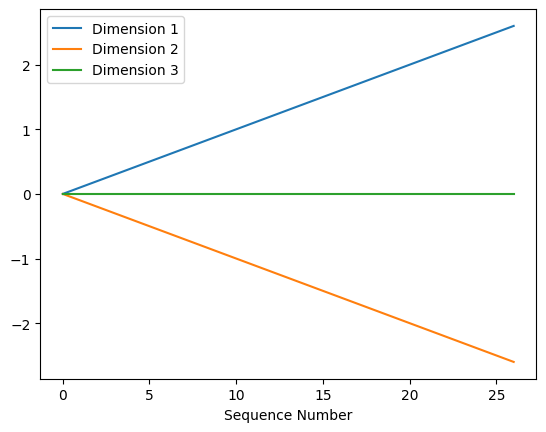

In [33]:
# Plot the positional encodings
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

Você observará que as palavras estão mais próximas, mas empregar uma função linear ainda apresenta as mesmas desvantagens.

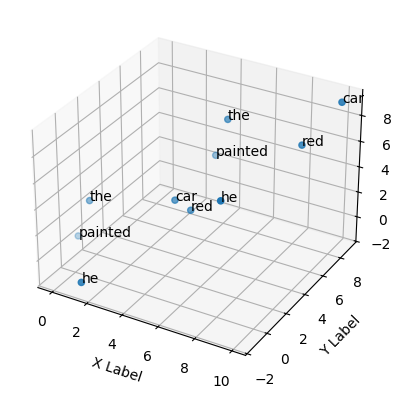

In [37]:
pos_embding=my_embeddings + pe[0:samples,:].numpy()
plot_embdings(pos_embeddings,tokenizer(my_tokens),vocab)

Ao examinar as codificações posicionais, você notará que as palavras parecem estar mais próximas. No entanto, é importante reconhecer que o uso de uma função linear introduz desvantagens semelhantes. Embora as palavras possam parecer mais próximas, você ainda encontrará certas limitações associadas às codificações posicionais lineares. Essas limitações incluem o potencial de amplificar magnitudes, o que pode impactar a capacidade do modelo de capturar efetivamente informações posicionais diferenciadas. Para lidar com esses desafios, abordagens e funções alternativas podem ser exploradas para fornecer codificações posicionais mais sensíveis ao contexto e adaptáveis.

Funções periódicas, como funções seno e cosseno, possuem a propriedade de periodicidade. Isso significa que elas repetem seus valores em um intervalo regular, evitando que cresçam muito rapidamente.

In [38]:
pe = torch.cat((torch.sin(2 * 3.14 * position / 6),
                0 * position + 1,
                0 * position + 1),
               1)

In [39]:
pos_embedding = my_embeddings + pe[0:samples, :].numpy()

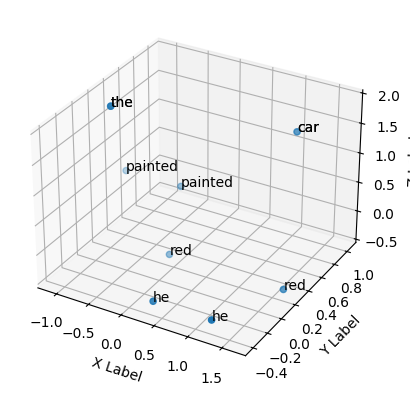

In [40]:
plot_embdings(pos_embedding, tokenizer(my_tokens), vocab)

A primeira dimensão de **$pe$** segue um padrão de onda senoidal, enquanto a 2ª e a 3ª dimensões têm valores constantes. Isso é mostrado no gráfico abaixo.

In [41]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

Você observou uma característica intrigante nos embeddings de palavras: eles são posicionados próximos o suficiente para manter proximidade enquanto permanecem suficientemente distintos um do outro. No entanto, há uma exceção notável quando se trata do embedding para "car". Essa anomalia surge porque a onda senoidal usada na codificação posicional é inerentemente periódica, conforme ilustrado na imagem abaixo, onde você pode observar a natureza repetitiva da função seno. Consequentemente, a codificação posicional para "car" em diferentes locais dentro da sequência permanece a mesma.

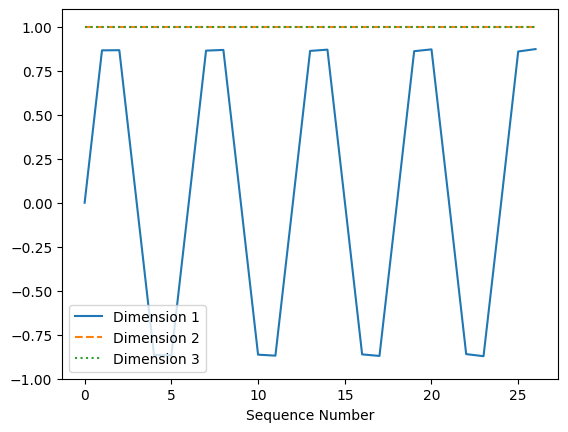

In [42]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

Ao incorporar funções seno e cosseno com frequências variadas, você pode efetivamente codificar sequências de diferentes comprimentos. Como demonstrado aqui, fica evidente que essas codificações posicionam? os elementos de tal forma que eles mantêm proximidade enquanto ainda preservam sua distinção uns dos outros.

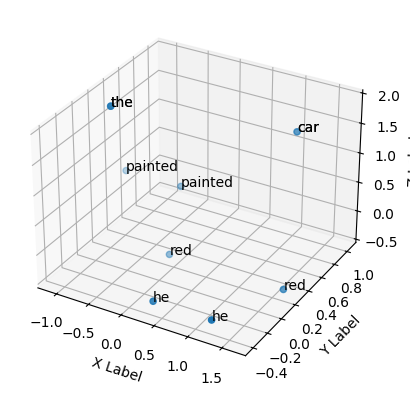

In [45]:
pe=torch.cat((torch.cos(2*3.14*position/25), 
              torch.sin(2*3.14*position/25),  
              torch.sin(2*3.14*position/5)), 
             1)
pos_embding=my_embeddings + pe[0:samples,:].numpy()
plot_embdings(pos_embedding,tokenizer(my_tokens),vocab)

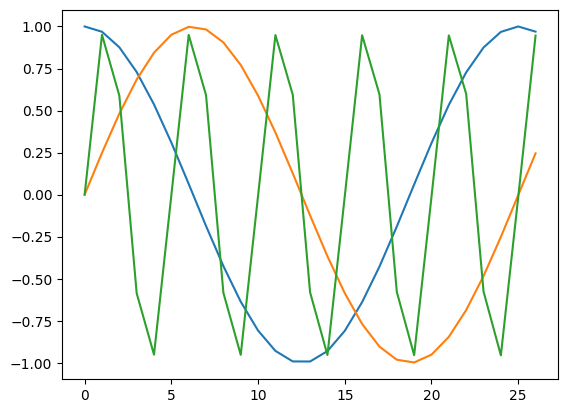

In [46]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

No geral, funções periódicas fornecem um meio mais expressivo e adaptável de codificar informações posicionais em sequências, tornando-as uma escolha preferida em modelos modernos de sequência para sequência, como transformadores. Elas oferecem recursos aprimorados para modelar dependências de curto e longo alcance, que são cruciais para tarefas em processamento de linguagem natural e outros domínios. Você pode usar a seguinte classe para aplicar a Codificação Posicional. A probabilidade de abandono é aplicada às codificações posicionais para evitar overfitting.

In [47]:
from torch import nn

In [48]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

### Encoder layer
#### O que é autoatenção?

Cada palavra (ou token) em uma frase é comparada a todas as outras palavras, incluindo ela mesma, para determinar quanta atenção ou importância deve ser atribuída a cada palavra. Três conjuntos de vetores - consulta, chave e valor são criados para os tokens. Vamos dar uma olhada em uma analogia que pintará uma imagem melhor para esses vetores.

- Consulta (query): quando você insere uma consulta de pesquisa em um mecanismo de busca como o Google, o texto que você insere na barra de pesquisa serve como a consulta. Por exemplo, se você pesquisar por "melhores smartphones", esta é sua consulta.
- Chave (key): o mecanismo de busca indexou e armazenou informações de páginas da web em toda a internet. Cada página da web contém uma variedade de informações textuais, incluindo títulos, cabeçalhos, conteúdo e metadados. Todo esse texto serve como chaves. No contexto da sua consulta, as chaves podem incluir palavras e frases encontradas em títulos, cabeçalhos e conteúdo de páginas da web.
- Valor (value): quando você envia sua consulta, os algoritmos do mecanismo de busca usam a consulta para encontrar as páginas da web mais relevantes em seu banco de dados. Essas páginas da web são os valores. O mecanismo de busca retorna uma lista de páginas da web (resultados da pesquisa) que são consideradas as melhores correspondências para sua consulta com base em seu conteúdo e relevância para as chaves associadas à sua consulta.

#### nn.TransformerEncoderLayer

A Camada do Codificador do Transformador (Transformer Encoder Layer) é uma camada de rede especializada comumente usada para processar dados sequenciais. Diferentemente de uma camada linear padrão, ela incorpora um conjunto exclusivo de parâmetros projetados para capturar relacionamentos intrincados entre amostras de dados. Em sua implementação, você pode utilizar `nn.TransformerEncoderLayer`. Considere a sequência de embeddings:

In [49]:
my_embdings=embedding(torch.tensor(my_index))
my_embdings

tensor([[ 1.2352, -1.3991, -1.3144],
        [-1.0920, -0.4955, -0.5597],
        [-1.8018, -0.8059,  0.8867],
        [ 0.9886,  0.0384,  0.2071],
        [ 0.7721, -0.7771, -1.3929],
        [ 1.2352, -1.3991, -1.3144],
        [-1.0920, -0.4955, -0.5597],
        [-1.8018, -0.8059,  0.8867],
        [ 0.7721, -0.7771, -1.3929],
        [ 0.9886,  0.0384,  0.2071]], grad_fn=<EmbeddingBackward0>)

Há 10 embaddings, cada uma com 3 dimensões

In [50]:
my_embdings.shape

torch.Size([10, 3])

Esta linha de código inicializa uma Camada de Codificador de Transformador no PyTorch usando a classe nn.TransformerEncoderLayer. Vamos dividir seus componentes:

- `d_model=3`: Este parâmetro especifica a dimensionalidade dos recursos de entrada e saída do modelo. Neste caso, cada vetor de entrada e saída terá um tamanho de 3. Você pode pensar nisso como a "largura" do modelo.

- `nhead=1`: Ele define o número de cabeças de atenção no mecanismo de autoatenção de múltiplas cabeças. Neste caso, há apenas uma cabeça de atenção, o que significa que o modelo executará autoatenção de cabeça única. No contexto de transformadores, "n cabeças" referem-se ao número de mecanismos de atenção paralelos usados ​​para capturar diversos padrões e dependências nos dados simultaneamente.

- `dim_feedforward=1`: Este parâmetro define a dimensionalidade da rede neural feedforward usada dentro da camada Transformer. A rede feedforward é responsável por processar a saída de atenção. Aqui, ele tem uma dimensão extremamente baixa de 1, que é anormalmente pequena e pode não ter um bom desempenho na prática. Na prática, esse valor é tipicamente muito maior para capturar padrões complexos.

- `dropout=0`: Dropout é uma técnica de regularização usada para evitar overfitting ao definir aleatoriamente uma fração de unidades de entrada para zero durante o treinamento. Uma taxa de dropout de 0 significa que nenhum dropout será aplicado nesta camada.

In [51]:
encoder_layer = nn.TransformerEncoderLayer(
    d_model=3,
    nhead=1,
    dim_feedforward=1,
    dropout=0
)

No contexto de transformadores, seu objetivo é treinar o modelo para receber uma sequência de entrada e efetivamente gerar outra sequência como sua saída, uma tarefa fundamental que fundamenta uma ampla gama de tarefas de processamento de linguagem natural e de sequência para sequência.

In [52]:
out = encoder_layer(my_embdings)
out

tensor([[ 1.3382, -0.2729, -1.0652],
        [-1.3484,  1.0435,  0.3049],
        [-1.1314, -0.1691,  1.3005],
        [ 1.3925, -0.4825, -0.9100],
        [ 0.9224,  0.4672, -1.3896],
        [ 1.3382, -0.2729, -1.0652],
        [-1.3484,  1.0435,  0.3049],
        [-1.1314, -0.1691,  1.3005],
        [ 0.9224,  0.4672, -1.3896],
        [ 1.3925, -0.4825, -0.9100]], grad_fn=<NativeLayerNormBackward0>)

No contexto de transformadores, seu objetivo é treinar o modelo para receber uma sequência de entrada e efetivamente gerar outra sequência como sua saída, uma tarefa fundamental que fundamenta uma ampla gama de tarefas de processamento de linguagem natural e de sequência para sequência.

In [53]:
out.mean(dim = 1)

tensor([ 0.0000e+00,  3.9736e-08, -3.9736e-08,  3.9736e-08,  0.0000e+00,
         0.0000e+00,  3.9736e-08, -3.9736e-08,  0.0000e+00,  3.9736e-08],
       grad_fn=<MeanBackward1>)

Você pode acessar os parâmetros do transformador, que abrangem vários componentes cruciais. Entre eles, os parâmetros key, query e value são particularmente significativos, desempenhando papéis essenciais no mecanismo de atenção do modelo e na funcionalidade geral.

In [54]:
params_dict = encoder_layer.state_dict()
# Print the parameter names and shapes
for name, param in params_dict.items():
    print(name, param.shape)

self_attn.in_proj_weight torch.Size([9, 3])
self_attn.in_proj_bias torch.Size([9])
self_attn.out_proj.weight torch.Size([3, 3])
self_attn.out_proj.bias torch.Size([3])
linear1.weight torch.Size([1, 3])
linear1.bias torch.Size([1])
linear2.weight torch.Size([3, 1])
linear2.bias torch.Size([3])
norm1.weight torch.Size([3])
norm1.bias torch.Size([3])
norm2.weight torch.Size([3])
norm2.bias torch.Size([3])


In [55]:
# The key, query, and value parameters are shown here
embed_dim=3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

## Consulta (query), chave (key) e valor (value)

No contexto de autoatenção em um transformador, você pode executar as seguintes projeções:

**Query (Q)**: $Q = XW^Q$

**Key (K)**: $K = XW^K$

**Value (V)**: $V = XW^V$

Aqui, $X$ representa os embeddings e $W$ representa os pesos aprendíveis.

In [56]:
Q = my_embdings@q_proj_weight
K = my_embdings@k_proj_weight
V = my_embdings@v_proj_weight

Attention scores:
$
   \text{Scores} = \frac{QK^T}{\sqrt{d_k}}
$

In [57]:
scores=Q@K.T/np. sqrt(embed_dim)
scores

tensor([[-0.8797,  0.5552,  0.7518, -0.5653, -0.4758, -0.8797,  0.5552,  0.7518,
         -0.4758, -0.5653],
        [ 0.1807, -0.0737,  0.1346,  0.1026,  0.0127,  0.1807, -0.0737,  0.1346,
          0.0127,  0.1026],
        [ 0.6134, -0.5483, -1.1106,  0.4826,  0.4603,  0.6134, -0.5483, -1.1106,
          0.4603,  0.4826],
        [-0.2862,  0.1401, -0.0124, -0.1682, -0.0819, -0.2862,  0.1401, -0.0124,
         -0.0819, -0.1682],
        [-0.6319,  0.4810,  0.9181, -0.4464, -0.4367, -0.6319,  0.4810,  0.9181,
         -0.4367, -0.4464],
        [-0.8797,  0.5552,  0.7518, -0.5653, -0.4758, -0.8797,  0.5552,  0.7518,
         -0.4758, -0.5653],
        [ 0.1807, -0.0737,  0.1346,  0.1026,  0.0127,  0.1807, -0.0737,  0.1346,
          0.0127,  0.1026],
        [ 0.6134, -0.5483, -1.1106,  0.4826,  0.4603,  0.6134, -0.5483, -1.1106,
          0.4603,  0.4826],
        [-0.6319,  0.4810,  0.9181, -0.4464, -0.4367, -0.6319,  0.4810,  0.9181,
         -0.4367, -0.4464],
        [-0.2862,  

Você pode calcular os pesos de atenção usando a função softmax aplicada às pontuações e então multiplicá-los pelos valores:

$O = \text{softmax}(\text{Pontuações})\cdot V$

In [58]:
head=nn.Softmax(dim=1)(scores)@V
head

tensor([[-0.0713,  0.9085,  0.3635],
        [-0.0104,  0.2539, -0.0034],
        [ 0.0564, -0.2545, -0.2460],
        [ 0.0033,  0.3555,  0.1067],
        [-0.0926,  0.9313,  0.3337],
        [-0.0713,  0.9085,  0.3635],
        [-0.0104,  0.2539, -0.0034],
        [ 0.0564, -0.2545, -0.2460],
        [-0.0926,  0.9313,  0.3337],
        [ 0.0033,  0.3555,  0.1067]], grad_fn=<MmBackward0>)

No contexto da atenção multicabeça, você pode particionar a dimensão de incorporação em $h$ subespaços, cada um com uma dimensão de $d/h$, e aplicar independentemente o mecanismo de atenção a esses componentes menores. Após a operação de atenção, você pode coletar as saídas e continuar com as operações de matriz subsequentes.

### Pesos de atenção e transformação linear

#### Pesos de atenção Softmax (softmax attention weights)

Após calcular as pontuações de atenção, você pode prosseguir com as transformações lineares da seguinte forma:

1. **Saída concatenada**: Você pode concatenar os vetores de saída individuais da seguinte forma:

$$
O_{\text{concat}} = [O_1, O_2, \ldots, O_h]
$$

2. **Saída final**: A saída final é obtida aplicando uma transformação linear à saída concatenada:

$$
O_{\text{final}} = O_{\text{concat}}W^O + b^O
$$

Aqui, $W^O$ representa a matriz de peso e $b^O$ representa o vetor de viés para a transformação linear.

Essas equações descrevem os elementos fundamentais da autoatenção multicabeça em um transformador. Embora haja várias considerações adicionais, elas dizem mais respeito à otimização do treinamento e são semelhantes às práticas comuns em redes neurais padrão.

### Múltiplas camadas de atenção:
Semelhante a redes neurais profundas que podem ter múltiplas camadas ocultas, os transformadores também podem ser configurados com múltiplas camadas de atenção.

**`nn.TransformerEncoder`** é um módulo que representa uma pilha de múltiplas camadas de codificador de transformador. Vamos dividir os parâmetros que você forneceu:

**encoder_layer**: Este parâmetro especifica o tipo de camada de codificador de transformador que você deseja usar dentro da pilha. No seu caso, você definiu uma camada de codificador usando `nn.TransformerEncoderLayer` com configurações específicas. O encoder_layer será repetido várias vezes na pilha.

**num_layers=2**: Este parâmetro indica o número de camadas de codificador para empilhar umas sobre as outras dentro do `nn.TransformerEncoder`. No seu exemplo, você escolheu empilhar 2 camadas de codificador.

In [59]:
transformer_encoder = nn.TransformerEncoder(
                                            encoder_layer,
                                            num_layers=2
)

In [61]:
# Display the toher layer
params_dict = transformer_encoder.state_dict()

for name, param in params_dict.items():
    print(name, " | ", param.shape)

layers.0.self_attn.in_proj_weight  |  torch.Size([9, 3])
layers.0.self_attn.in_proj_bias  |  torch.Size([9])
layers.0.self_attn.out_proj.weight  |  torch.Size([3, 3])
layers.0.self_attn.out_proj.bias  |  torch.Size([3])
layers.0.linear1.weight  |  torch.Size([1, 3])
layers.0.linear1.bias  |  torch.Size([1])
layers.0.linear2.weight  |  torch.Size([3, 1])
layers.0.linear2.bias  |  torch.Size([3])
layers.0.norm1.weight  |  torch.Size([3])
layers.0.norm1.bias  |  torch.Size([3])
layers.0.norm2.weight  |  torch.Size([3])
layers.0.norm2.bias  |  torch.Size([3])
layers.1.self_attn.in_proj_weight  |  torch.Size([9, 3])
layers.1.self_attn.in_proj_bias  |  torch.Size([9])
layers.1.self_attn.out_proj.weight  |  torch.Size([3, 3])
layers.1.self_attn.out_proj.bias  |  torch.Size([3])
layers.1.linear1.weight  |  torch.Size([1, 3])
layers.1.linear1.bias  |  torch.Size([1])
layers.1.linear2.weight  |  torch.Size([3, 1])
layers.1.linear2.bias  |  torch.Size([3])
layers.1.norm1.weight  |  torch.Size([3]

## Classificação de texto
Vamos construir um modelo de classificação de texto usando PyTorch e torchtext para classificar artigos de notícias em uma das quatro categorias: Mundo, Esportes, Negócios e Ciência/Tecnologia.

### Importar conjunto de dados

Carregue o conjunto de dados AG_NEWS para a divisão do trem e divida-o em texto de entrada e rótulos correspondentes:

In [62]:
train_iter= AG_NEWS(split="train")

O conjunto de dados AG_NEWS em torchtext não suporta indexação direta como uma lista ou tupla. Não é um conjunto de dados de acesso aleatório, mas sim um conjunto de dados iterável que precisa ser usado com um iterador. Essa abordagem é mais eficaz para dados de texto.

In [63]:
y, text = next(iter(train_iter))
print(y, text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [64]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
ag_news_label[y]

'Business'

In [65]:
# Use the dataset to find all the classes
num_class = len(set([label for (label, text) in train_iter]))
num_class

4

In [66]:
# Build the vocabulary as before, just using the AG dataset to obtain token indices
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [67]:
# Some token indices
vocab(["age", "hello"])

[2120, 12544]

### Dataset
Você pode converter o conjunto de dados em conjuntos de dados no estilo de mapa e, em seguida, executar uma divisão aleatória para criar conjuntos de dados de treinamento e validação separados. O conjunto de dados de treinamento conterá 95% das amostras, enquanto o conjunto de dados de validação conterá os 5% restantes. Esses conjuntos de dados podem ser usados ​​para treinar e avaliar um modelo de aprendizado de máquina para classificação de texto no conjunto de dados AG_NEWS.

In [68]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [69]:
# Check if CUDA-compatible GPU is available in the system using PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data loader
No PyTorch, a função **`collate_fn`** é usada em conjunto com carregadores de dados para personalizar a maneira como os lotes são criados a partir de amostras individuais. O código fornecido define uma função `collate_batch` no PyTorch, que é usada com carregadores de dados para personalizar a criação de lotes a partir de amostras individuais. Ela processa um lote de dados, incluindo rótulos e sequências de texto. Ela aplica as funções `label_pipeline` e `text_pipeline` para pré-processar os rótulos e textos, respectivamente. Os dados processados ​​são então convertidos em tensores PyTorch e retornados como uma tupla contendo o tensor de rótulo, tensor de texto e tensor de deslocamentos representando as posições iniciais de cada sequência de texto no tensor combinado. A função também garante que os tensores retornados sejam movidos para o dispositivo especificado (por exemplo, GPU) para computação eficiente.

In [70]:
from torch.nn.utils.rnn import pad_sequence

In [71]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)


    return label_list.to(device), text_list.to(device)

Você pode converter os objetos do conjunto de dados em um carregador de dados aplicando a função collate.

In [72]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [76]:
# See the output sequence when you have the label, text, and offsets for each batch
label, seqence = next(iter(valid_dataloader))
print(label,'\n -*- \n', seqence)

tensor([2, 0, 0, 2, 2, 3, 0, 2, 2, 3, 2, 1, 1, 2, 0, 0, 2, 2, 3, 0, 3, 2, 3, 3,
        3, 3, 3, 1, 1, 1, 2, 3, 3, 1, 2, 3, 2, 3, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2,
        0, 0, 1, 3, 0, 2, 3, 2, 0, 3, 3, 1, 0, 3, 3, 1]) 
 -*- 
 tensor([[ 1849,    36,   122,  ...,     0,     0,     0],
        [ 4733,     3, 13298,  ...,     0,     0,     0],
        [  424,  4369,   154,  ...,     0,     0,     0],
        ...,
        [  523,  1087,    21,  ...,     0,     0,     0],
        [ 3396,     4,   275,  ...,     0,     0,     0],
        [ 3460,   842, 13895,  ...,     0,     0,     0]])


### Neural network
Você criou uma rede neural para um modelo de classificação de texto usando uma camada `EmbeddingBag`, seguida por uma camada de saída softmax. Além disso, você inicializou o modelo usando um método específico.

In [77]:
class Net(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        
        self,
        vocab_size,
        num_class,
        embedding_dim=100,
        nhead=5,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1):

        super().__init__()

        self.emb = nn.Embedding(vocab_size,embedding_dim)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, num_class)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [78]:
y,x=next(iter(train_dataloader))
x

tensor([[ 4202,  5481,     3,  ...,     0,     0,     0],
        [  563, 24193,    38,  ...,     0,     0,     0],
        [ 1099,  1985,     4,  ...,     0,     0,     0],
        ...,
        [ 3807,  5179,   402,  ...,     0,     0,     0],
        [ 4630,   957,  1218,  ...,     0,     0,     0],
        [ 2365,    10,  1213,  ...,     0,     0,     0]])

In [79]:
emsize=64

In [80]:
vocab_size=len(vocab)
vocab_size

95811

In [81]:
num_class

4

In [82]:
# Create the model
model = Net(vocab_size=vocab_size, num_class=4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

A linha de código `predicted_label=model(text, offsets)` é usada para obter rótulos previstos de um modelo de aprendizado de máquina para um texto de entrada fornecido e seus deslocamentos correspondentes. O `model` é o modelo de aprendizado de máquina sendo usado para classificação de texto ou tarefas semelhantes.

In [83]:
predicted_label=model(x)

Você pode verificar o formato de saída do seu modelo. Neste caso, o modelo é treinado com um tamanho de mini-lote de 64 amostras. A camada de saída do modelo produz 4 logits para cada neurônio, correspondendo às quatro classes na tarefa de classificação. Você também pode criar uma função para encontrar a precisão dada a um conjunto de dados.

In [84]:
predicted_label.shape

torch.Size([64, 4])

In [85]:
x.shape

torch.Size([64, 83])

A função **`predict`** recebe um texto e um pipeline de texto, que pré-processa o texto para aprendizado de máquina. Ela usa um modelo pré-treinado para prever o rótulo do texto para classificação de texto no conjunto de dados AG_NEWS. A função retorna o rótulo previsto como resultado.

In [86]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)

        output = model(text)
        return ag_news_label[output.argmax(1).item() + 1]

In [87]:
predict("I like sports and stuff",text_pipeline )

'Business'

In [88]:
# Function to evaluate the model's accuracy on a dataset
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

Você prossegue avaliando o modelo e, após observação, descobre que seu desempenho não é melhor do que a média. Esse resultado é esperado, considerando que o modelo ainda não passou por nenhum treinamento.

In [89]:
evaluate(test_dataloader, model)

0.25

### Treinamento

Você define a taxa de aprendizado (LR) como 0,1, o que determina o tamanho do passo no qual o otimizador atualiza os parâmetros do modelo durante o treinamento. O critério CrossEntropyLoss é usado para calcular a perda entre as saídas previstas do modelo e os rótulos da verdade básica. Essa função de perda é comumente empregada para tarefas de classificação multiclasse.

O otimizador escolhido é o Stochastic Gradient Descent (SGD), que otimiza os parâmetros do modelo com base nos gradientes computados em relação à função de perda. O otimizador SGD usa a taxa de aprendizado especificada para controlar o tamanho das atualizações de peso.

Além disso, um agendador de taxa de aprendizado é definido usando StepLR. Esse agendador ajusta a taxa de aprendizado durante o treinamento, reduzindo-a por um fator (gama) de 0,1 após cada época (passo) para melhorar a convergência e ajustar o desempenho do modelo. Esses componentes juntos formam a configuração essencial para treinar uma rede neural usando a taxa de aprendizado especificada, o critério de perda, o otimizador e o agendador de taxa de aprendizado.

**Observação: o treinamento leva muito tempo com CPU. Se você tiver acesso à GPU, pode descomentar o código abaixo e executá-lo para treinar o modelo. Caso contrário, você pode pular diretamente para a próxima seção, onde recebeu um modelo treinado e o salvou para explorá-lo.**

In [92]:
# LR=0.1

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

Treinando o modelo para 10 épocas.

>Pule esta etapa se você não tiver GPU. Recupere e use o modelo que foi treinado para 100 épocas e salvo, na próxima etapa.

In [93]:
# EPOCHS = 10
# cum_loss_list=[]
# acc_epoch=[]
# acc_old=0

# for epoch in tqdm(range(1, EPOCHS + 1)):
#     model.train()
#     cum_loss=0
#     for idx, (label, text) in enumerate(train_dataloader):
#         optimizer.zero_grad()
#         label, text=label.to(device), text.to(device)


#         predicted_label = model(text)
#         loss = criterion(predicted_label, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
#         cum_loss+=loss.item()
#     print("Loss",cum_loss)

#     cum_loss_list.append(cum_loss)
#     accu_val = evaluate(valid_dataloader)
#     acc_epoch.append(accu_val)

#     if accu_val > acc_old:
#       acc_old= accu_val
#       torch.save(model.state_dict(), 'my_model.pth')

# save_list_to_file(lst=cum_loss_list, filename="loss.pkl")
# ave_list_to_file(lst=acc_epoch, filename="acc.pkl")

In [95]:
# ! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth
# ! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl
# ! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/loss.pkl

In [96]:
import requests

# URLs dos arquivos
urls = [
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/my_model.pth",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/acc.pkl",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX05RNEN/loss.pkl"
]

# Baixar os arquivos
for url in urls:
    filename = url.split("/")[-1]
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"{filename} baixado com sucesso!")


my_model.pth baixado com sucesso!
acc.pkl baixado com sucesso!
loss.pkl baixado com sucesso!


In [99]:
cum_loss_list=load_list_from_file("loss.pkl")
acc_epoch=load_list_from_file("acc.pkl")

In [100]:
pretrained_model_path = 'my_model.pth'
model_ = Net(vocab_size=vocab_size, num_class=4).to(device)
model_.load_state_dict(torch.load(pretrained_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

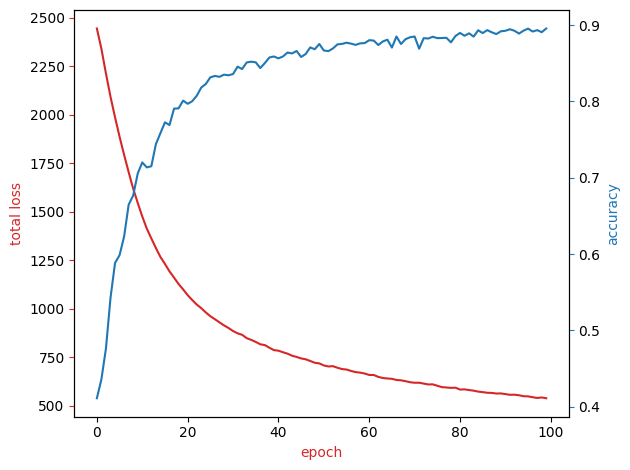

In [101]:
plot(cum_loss_list,acc_epoch)

In [102]:
# evaluate the results on the test data; you achieve over 80%.
evaluate(test_dataloader, model_)

0.8822368421052632

A função `plot_tras` recebe palavras de entrada e um modelo de transformador como argumentos. Ela tokeniza as palavras de entrada, aplica as camadas de codificação posicional e de incorporação do modelo e extrai pesos de projeção para consulta, chave e valor do state_dict do modelo. Usando atenção de produto escalar, ela calcula e visualiza pontuações de atenção como um mapa de calor. O softmax dessas pontuações também é visualizado como um mapa de calor separado. A função calcula a cabeça de atenção multiplicando as pontuações softmax por valores e emprega t-SNE para visualizar tanto as incorporações quanto as cabeças de atenção, oferecendo insights sobre os mecanismos de atenção dentro do modelo de transformador.

Rescuing an Old Saver If you think you may need to help your elderly relatives with their finances, don't be shy about having the money talk -- soon.


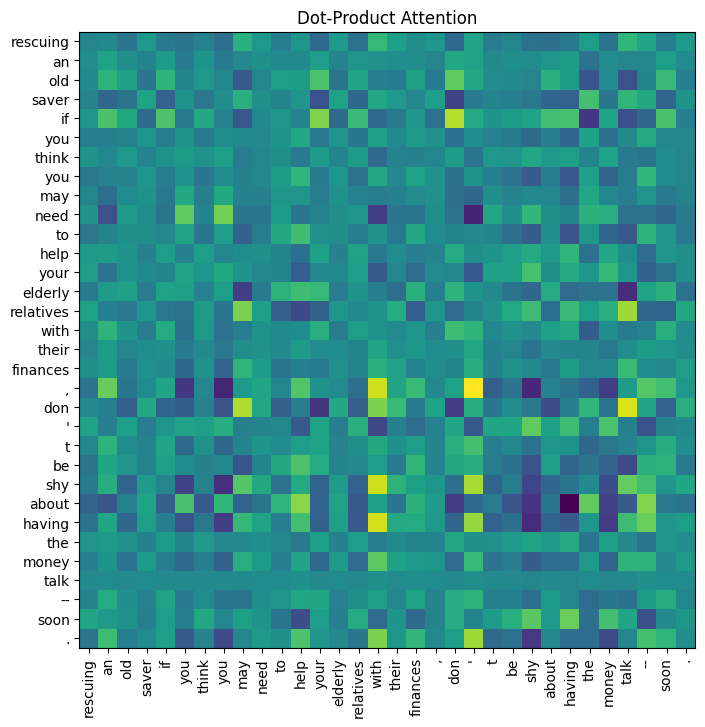

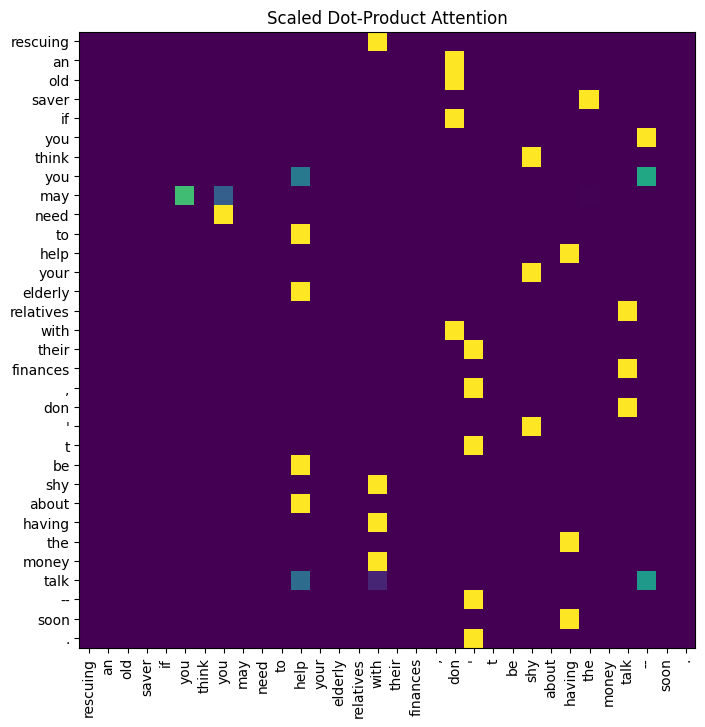

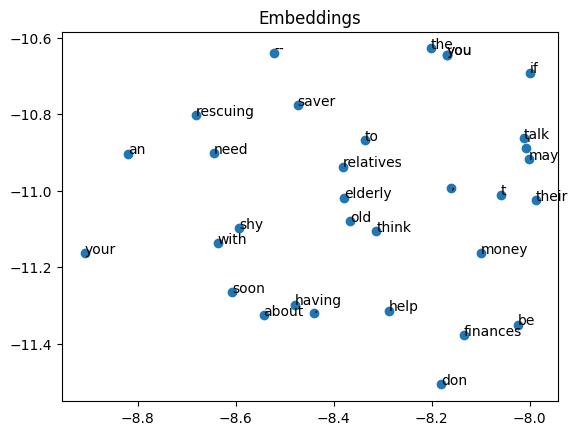

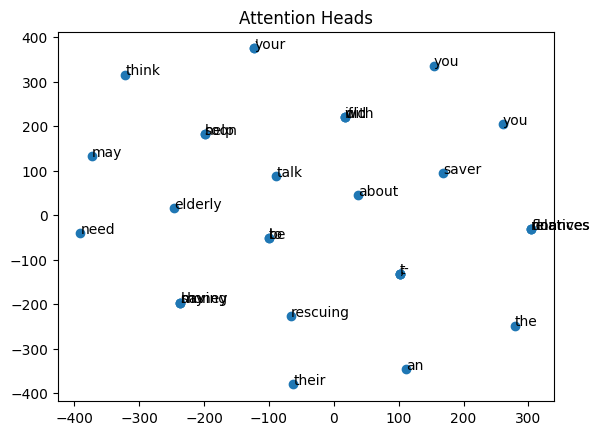

In [103]:
sample=15

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

Na atenção de produto escalar (scaled dot-product attention), se você olhar do eixo x, "rescuing" é importante com palavras como em soon, don, their, help and an.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.


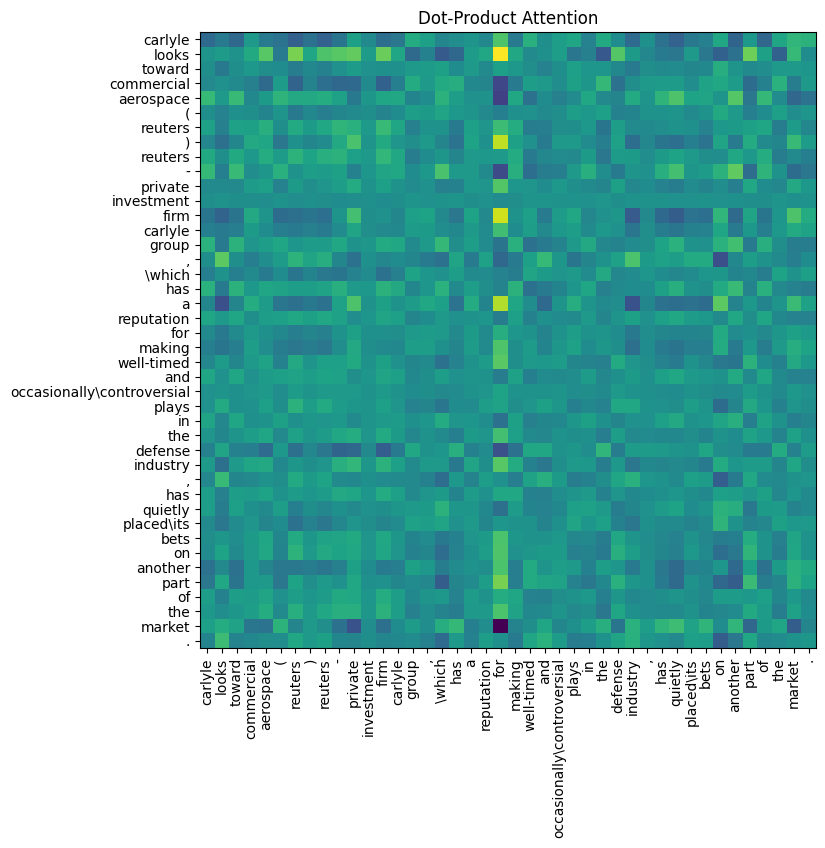

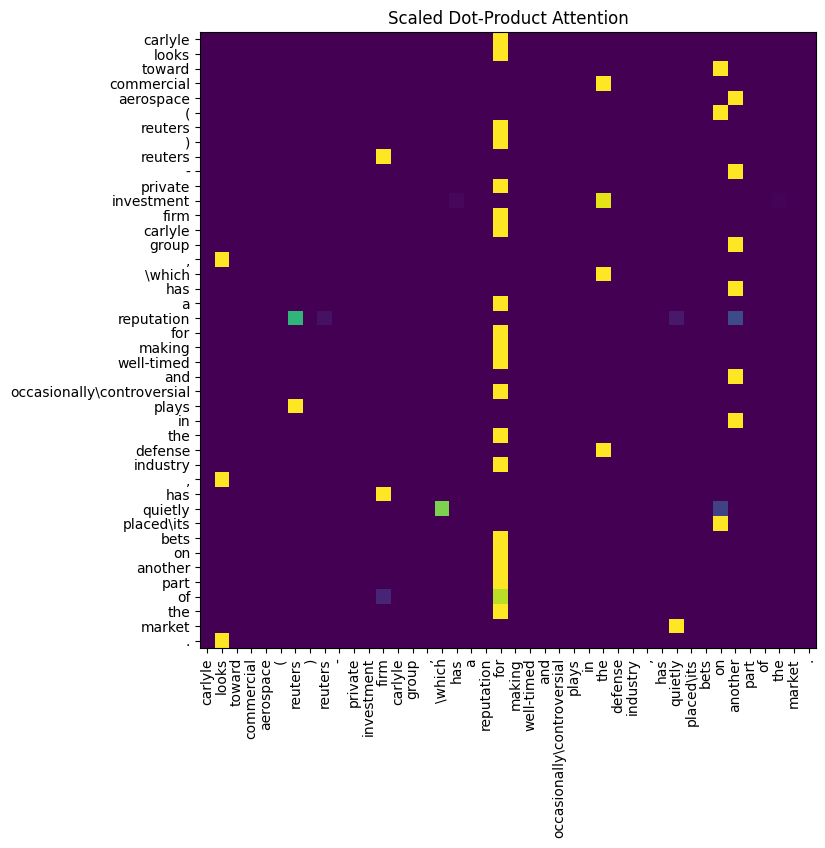

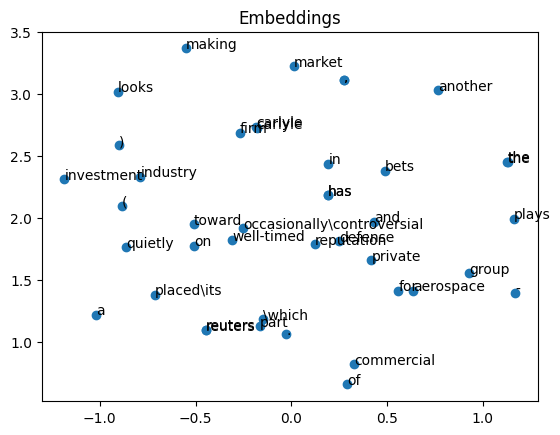

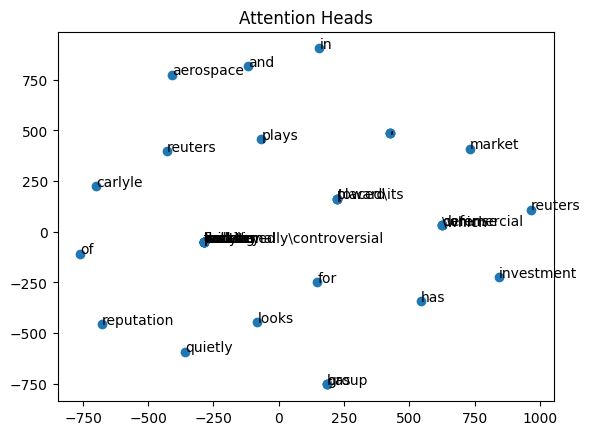

In [104]:
sample=1

words=train_dataset[sample][1]
print(words)
plot_tras(words, model)

### Prever um artigo

In [105]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [106]:
result = predict(article, text_pipeline)

In [113]:
markdown_content = f'''
<div style="background-color: white; padding: 8px;">
    <p>{article}</p>
    <h4>The category of the news article: {result}</h4>
</div>
'''

In [114]:
md(markdown_content)


<div style="background-color: white; padding: 8px;">
    <p>Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points.</p>
    <h4>The category of the news article: World</h4>
</div>
